<a href="https://colab.research.google.com/github/luciainnocenti/Homework3-PACS/blob/master/MLDL_Homework3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Import libraries**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms

from PIL import Image
from tqdm import tqdm


from numpy import random 

random.seed(33)

#**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

BATCH_SIZE = 128     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 20      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [0]:
#V1

alfa = 1
LR = 1e-4

In [0]:
#V2

alfa = 1
LR = 1e-5

In [0]:
#V3

alfa = 1
LR = 1e-6

# Import and definition

In [4]:
# Clone github repository with data
!git clone https://github.com/luciainnocenti/Homework3-PACS.git
!mv 'Homework3-PACS' 'HW_PACS'

from HW_PACS.dataset import PACS_Dataset 

Cloning into 'Homework3-PACS'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 10120 (delta 9), reused 0 (delta 0), pack-reused 10102
Receiving objects: 100% (10120/10120), 174.21 MiB | 12.19 MiB/s, done.
Resolving deltas: 100% (52/52), done.
Checking out files: 100% (9995/9995), done.


In [4]:
## Define transforms for training phase
#transformer = transforms.Compose([transforms.Resize(256),   
#                                      transforms.CenterCrop(224),
#                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
#])
#rootPhoto = "HW_PACS/PACS/photo"
#photos = PACS_Dataset(root = rootPhoto, transform = transformer)
#
#rootArt_painting = "HW_PACS/PACS/art_painting"
#art_painting = PACS_Dataset(root = rootArt_painting, transform = transformer)
#
#photos_dataloader = DataLoader(photos, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
#art_painting_dataloader = DataLoader(art_painting, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
#
#print(photos.meanAndStd(photos_dataloader))
#print(art_painting.meanAndStd(art_painting_dataloader))

(tensor([0.5088, 0.4744, 0.4307]), tensor([0.2725, 0.2620, 0.2774]))
(tensor([0.5530, 0.5018, 0.4488]), tensor([0.2750, 0.2648, 0.2775]))


#**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),   
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
                                      transforms.Normalize((0.5088, 0.4744, 0.4307), (0.2725, 0.2620, 0.2774)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the test phase
test_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5530, 0.5018, 0.4488), (0.2750, 0.2648, 0.2775))                                    
])

#**Prepare Dataset**

In [6]:
rootPhoto = "HW_PACS/PACS/photo"
photos = PACS_Dataset(root = rootPhoto, transform = train_transform)

rootArt_painting = "HW_PACS/PACS/art_painting"
art_painting = PACS_Dataset(root = rootArt_painting, transform = test_transform)

# Check dataset sizes
print('Train Dataset: {}'.format(len(photos)))
print('Test Dataset: {}'.format(len(art_painting)))

Train Dataset: 1670
Test Dataset: 2048


#**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
photos_dataloader = DataLoader(photos, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
art_painting_dataloader = DataLoader(art_painting, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

#**Model without DANN**

##**Prepare Network**

In [8]:
from HW_PACS.gradient_reversal_example import alexNetDA 

net = alexNetDA(num_classes = 7)


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


##**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() 

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum

optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

#optimizer = optim.Adam(parameters_to_optimize, LR)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [10]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
cudnn.benchmark # Calling this optimizes runtime
running_corrects = 0
current_step = 0
# Start iterating over the epochs
# Iterate over the dataset
losses = []
accuracies = []
for epoch in range(NUM_EPOCHS):
  scheduler.step() 
  
  for images, labels in  tqdm(photos_dataloader):

    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights

    loss.backward()  # backward pass: computes gradients

    optimizer.step() # update weights based on accumulated gradients

    current_step += 1
    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()
    losses.append(loss.item())

  # Calculate Accuracy
  accuracy = running_corrects / float(len(photos))
  accuracies.append(accuracy)
  print("Accuracy on training set = "  + str(accuracy))
  running_corrects = 0
    

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  7%|▋         | 1/14 [00:02<00:37,  2.89s/it]

Step 0, Loss 1.834657073020935


 79%|███████▊  | 11/14 [00:07<00:01,  1.97it/s]

Step 10, Loss 1.3158570528030396


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.4598802395209581


 50%|█████     | 7/14 [00:05<00:05,  1.36it/s]

Step 20, Loss 0.7910177111625671


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.7239520958083833


 21%|██▏       | 3/14 [00:03<00:16,  1.53s/it]

Step 30, Loss 0.6162962913513184


 93%|█████████▎| 13/14 [00:08<00:00,  2.73it/s]

Step 40, Loss 0.38046374917030334


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.8640718562874251


 64%|██████▍   | 9/14 [00:07<00:04,  1.24it/s]

Step 50, Loss 0.2987176775932312


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.911377245508982


 36%|███▌      | 5/14 [00:04<00:10,  1.17s/it]

Step 60, Loss 0.2857263684272766


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9347305389221557


  7%|▋         | 1/14 [00:02<00:35,  2.74s/it]

Step 70, Loss 0.31792131066322327


 79%|███████▊  | 11/14 [00:07<00:01,  1.91it/s]

Step 80, Loss 0.18551801145076752


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9413173652694611


 50%|█████     | 7/14 [00:05<00:05,  1.35it/s]

Step 90, Loss 0.2353890836238861


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9497005988023952


 21%|██▏       | 3/14 [00:03<00:16,  1.47s/it]

Step 100, Loss 0.16565614938735962


 93%|█████████▎| 13/14 [00:08<00:00,  2.66it/s]

Step 110, Loss 0.2103806585073471


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9508982035928144


 64%|██████▍   | 9/14 [00:07<00:04,  1.24it/s]

Step 120, Loss 0.18364638090133667


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9580838323353293


 36%|███▌      | 5/14 [00:05<00:11,  1.23s/it]

Step 130, Loss 0.1302507370710373


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9646706586826347


  7%|▋         | 1/14 [00:02<00:35,  2.74s/it]

Step 140, Loss 0.17585782706737518


 79%|███████▊  | 11/14 [00:07<00:01,  1.93it/s]

Step 150, Loss 0.12995338439941406


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9610778443113772


 50%|█████     | 7/14 [00:05<00:05,  1.36it/s]

Step 160, Loss 0.11305443942546844


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9586826347305389


 21%|██▏       | 3/14 [00:03<00:16,  1.45s/it]

Step 170, Loss 0.12199421972036362


 93%|█████████▎| 13/14 [00:08<00:00,  2.66it/s]

Step 180, Loss 0.14531901478767395


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9610778443113772


 64%|██████▍   | 9/14 [00:07<00:04,  1.23it/s]

Step 190, Loss 0.13102807104587555


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9634730538922156


 36%|███▌      | 5/14 [00:04<00:10,  1.20s/it]

Step 200, Loss 0.10484744608402252


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9682634730538923


  7%|▋         | 1/14 [00:02<00:33,  2.57s/it]

Step 210, Loss 0.173848956823349


 79%|███████▊  | 11/14 [00:07<00:01,  1.89it/s]

Step 220, Loss 0.10744453966617584


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9688622754491018


 50%|█████     | 7/14 [00:05<00:05,  1.36it/s]

Step 230, Loss 0.1343015730381012


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9688622754491018


 21%|██▏       | 3/14 [00:03<00:15,  1.43s/it]

Step 240, Loss 0.10693290084600449


 93%|█████████▎| 13/14 [00:08<00:00,  2.72it/s]

Step 250, Loss 0.07951746881008148


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9706586826347305


 64%|██████▍   | 9/14 [00:06<00:03,  1.26it/s]

Step 260, Loss 0.15000149607658386


  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy on training set = 0.9778443113772455


 36%|███▌      | 5/14 [00:04<00:09,  1.10s/it]

Step 270, Loss 0.1430426388978958


100%|██████████| 14/14 [00:08<00:00,  1.72it/s]

Accuracy on training set = 0.9688622754491018


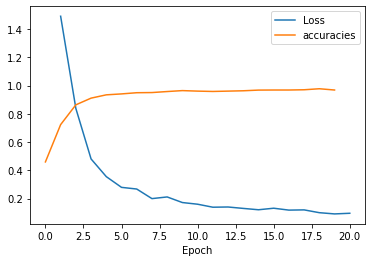

In [11]:
import numpy as np
import matplotlib.pyplot as plt

X = np.zeros(NUM_EPOCHS)
n = 0
cnt = 0
for l in losses:
  X[n] += l
  cnt += 1
  if( cnt == 14):
    X[n] = X[n] / 14
    n += 1
    cnt = 0
  
x_epochs = np.linspace(1,NUM_EPOCHS,NUM_EPOCHS)

plt.plot(x_epochs, X , accuracies, '-')
plt.xlabel("Epoch")
plt.legend(['Loss', 'accuracies'])

plt.show()

##**Test**

In [12]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode
losses = []
running_corrects = 0
for images, labels in tqdm(art_painting_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  loss = criterion(outputs, labels)
  losses.append(loss)
  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(art_painting))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 16/16 [00:08<00:00,  1.78it/s]

Test Accuracy: 0.453125


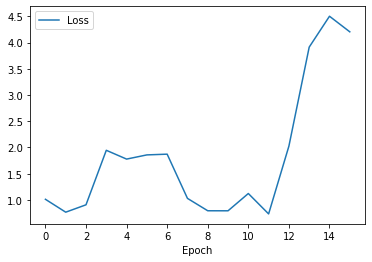

In [13]:
batches = np.linspace(0, 15, 16)
plt.plot(batches, losses, '-')
plt.xlabel("Epoch")
plt.legend(['Loss'])


In [14]:
loss.item()

4.203427314758301

# Model with DANN

## Network

In [0]:
net = alexNetDA(num_classes = 7)
net = net.to(DEVICE)

## Loss, Optim and Scheduler

In [0]:
criterion_class = nn.CrossEntropyLoss() 
criterion_domain = nn.CrossEntropyLoss()

parameters_to_optimize = net.parameters() 

optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#optimizer = optim.Adam(parameters_to_optimize, LR)


scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

## Test function

In [0]:
def testFunction(datasetName, epoch):  
  net = torch.load('model_epoch_' + str(epoch) + '.pt')
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode
  if (datasetName == 'photo'):
    dataLoader = DataLoader(photos, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
  elif( datasetName == 'artPainting'):
    dataLoader = DataLoader(art_painting, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

  lenLoader = len(dataLoader)
  iterator = iter(dataLoader)
  totalLen = 0
  running_corrects = 0
  criterion = nn.CrossEntropyLoss() 
  for i in range(lenLoader):
    t_img, t_label = next(iterator)

    t_img = t_img.to(DEVICE)
    t_label = t_label.to(DEVICE)

    # Forward Pass
    classes_output = net(t_img)

    loss = criterion(classes_output, t_label)

    # Get predictions
    _, preds = torch.max(classes_output.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == t_label.data).data.item()
    totalLen += len(t_img)

  # Calculate Accuracy
  accuracy = running_corrects / float(totalLen)

  print(f'Accuracy on  {datasetName}' f' during epoch {epoch}' f' is {accuracy}' f' loss is {loss}')

## Train 

In [0]:
#photos_dataloader = DataLoader(photos, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
#art_painting_dataloader = DataLoader(art_painting, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

max_batches = max(len(photos_dataloader), len(art_painting_dataloader))
min_batches = min(len(photos_dataloader), len(art_painting_dataloader))

In [20]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime
running_corrects = 0
current_step = 0
# Start iterating over the epochs
# Iterate over the dataset
for epoch in range(NUM_EPOCHS):
  scheduler.step() 
  iterPh = iter(photos_dataloader)
  iterAP = iter(art_painting_dataloader)
  for batch in range(max_batches):
    net.train() # Sets module in training mode
    optimizer.zero_grad() # Zero-ing the gradients
    if( batch == min_batches):
      iterPh = iter(photos_dataloader)
    images_source, labels_source = next(iterPh)
    labels_domain = torch.zeros(len(images_source), dtype=torch.long)
    
    # Bring data over the device of choice
    images_source = images_source.to(DEVICE)
    labels_source = labels_source.to(DEVICE)
    labels_domain = labels_domain.to(DEVICE)

  
    # Get the output for classes and domains; class_pred, domain_pred
    classes_output = net(images_source)
    # Compute the loss on the source domain
    loss_s_label = criterion_class(classes_output, labels_source)

    domain_output = net(images_source, alfa)

    # Compute the loss on the source domain
    loss_s_domain = criterion_domain(domain_output, labels_domain)

    # Get the output for targets
    targets, _ = next(iterAP)
    target_domain = torch.ones(len(targets), dtype=torch.long)

    # Bring data over the device of choice
    targets = targets.to(DEVICE)
    target_domain = target_domain.to(DEVICE)

    target_output = net(targets, alfa)

    # Compute the loss on the source domain
    loss_t_domain = criterion_domain(target_output,target_domain)

    loss = loss_s_label + loss_s_domain + loss_t_domain
    loss.backward()  # backward pass: computes gradients

    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

    print(f'[{batch+1}/{max_batches}] '
          f'class_loss: {loss_s_label.item():.4f} ' f's_domain_loss: {loss_s_domain.item():.4f} '
          f't_domain_loss: {loss_t_domain.item():.4f} '
          )  
  torch.save(net, 'model_epoch_{0}.pt'.format(epoch))
  testFunction('photo', epoch)
  testFunction('artPainting', epoch)
  

[1/16] class_loss: 2.0707 s_domain_loss: 0.9977 t_domain_loss: 0.4991 
[2/16] class_loss: 1.9446 s_domain_loss: 0.9673 t_domain_loss: 0.5191 
[3/16] class_loss: 1.9480 s_domain_loss: 0.9360 t_domain_loss: 0.5286 
[4/16] class_loss: 1.7551 s_domain_loss: 0.9015 t_domain_loss: 0.5658 
[5/16] class_loss: 1.7035 s_domain_loss: 0.8603 t_domain_loss: 0.6112 
[6/16] class_loss: 1.7963 s_domain_loss: 0.8032 t_domain_loss: 0.6419 
[7/16] class_loss: 1.7316 s_domain_loss: 0.7505 t_domain_loss: 0.6846 
[8/16] class_loss: 1.6178 s_domain_loss: 0.7053 t_domain_loss: 0.7412 
[9/16] class_loss: 1.4888 s_domain_loss: 0.6639 t_domain_loss: 0.7608 
[10/16] class_loss: 1.2486 s_domain_loss: 0.6355 t_domain_loss: 0.8032 
[11/16] class_loss: 1.2831 s_domain_loss: 0.6076 t_domain_loss: 0.8398 
[12/16] class_loss: 1.2915 s_domain_loss: 0.6012 t_domain_loss: 0.8469 
[13/16] class_loss: 1.0258 s_domain_loss: 0.5956 t_domain_loss: 0.8526 
[14/16] class_loss: 1.1303 s_domain_loss: 0.5828 t_domain_loss: 0.8485 
[

In [0]:
LR

In [0]:
alfa